Testing our model on validation dataset which is taken as test_dataset

In [1]:
import torch
import albumentations
import numpy as np
import matplotlib.pyplot as plt
from torch.nn import functional as F
from PIL import Image, ImageFile

In [ ]:
import sys
sys.path.append('../src')
from dataset import ClassificationDataset
from model import CaptchaModel

In [4]:
import glob
import os
from torch import nn
from sklearn import preprocessing, model_selection
image_files = glob.glob(os.path.join('../src/captcha_images_v2/', "*.png"))

In [5]:
targets_orig = [x.split("/")[-1][:-4] for x in image_files]
targets = [[c for c in x] for x in targets_orig]
targets_flat = [c for clist in targets for c in clist]

In [6]:
lbl_enc = preprocessing.LabelEncoder()
lbl_enc.fit(targets_flat)
targets_enc = [lbl_enc.transform(x) for x in targets]
targets_enc = np.array(targets_enc)
targets_enc = targets_enc+1

In [7]:
(
    _,
    test_imgs,
    _,
    test_targets,
    _,
    test_targets_orig,
) = model_selection.train_test_split(
    image_files, targets_enc, targets_orig, test_size=0.1, random_state=42
)

In [10]:
test_dataset = ClassificationDataset(
    image_paths = test_imgs,
    targets=test_targets,
    resize=(75,300)
)

In [11]:
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size = 8,
    num_workers = 8,
    shuffle= False
)

In [46]:
checkpoint = torch.load('../notebooks/crnn200.pt')
model.load_state_dict(checkpoint['state_dict'])
model.eval()

CaptchaModel(
  (conv1): Conv2d(3, 128, kernel_size=(3, 6), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(128, 64, kernel_size=(3, 6), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=1152, out_features=64, bias=True)
  (drop1): Dropout(p=0.2, inplace=False)
  (lstm): GRU(64, 32, num_layers=2, batch_first=True, dropout=0.25, bidirectional=True)
  (output): Linear(in_features=64, out_features=20, bias=True)
)

In [13]:
model = CaptchaModel(num_chars=len((lbl_enc.classes_)))
model.to('cuda')

CaptchaModel(
  (conv1): Conv2d(3, 128, kernel_size=(3, 6), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(128, 64, kernel_size=(3, 6), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=1152, out_features=64, bias=True)
  (drop1): Dropout(p=0.2, inplace=False)
  (lstm): GRU(64, 32, num_layers=2, batch_first=True, dropout=0.25, bidirectional=True)
  (output): Linear(in_features=64, out_features=20, bias=True)
)

In [23]:
tmp = iter(test_loader)
batch = next(tmp)
temp1 = batch["images"][0]
temp2 = batch['targets'][0]
temp1.shape, temp2.shape

(torch.Size([3, 75, 300]), torch.Size([5]))

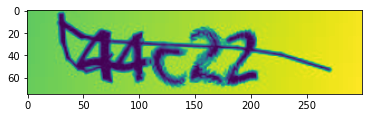

In [24]:
plt.imshow(temp1[0])

In [26]:
temp1 = temp1.cuda()
temp1 = torch.unsqueeze(temp1, 0)
temp1.shape

torch.Size([1, 3, 75, 300])

In [27]:
x, y = model(temp1)

Prediction of the model

In [29]:
from train import decode_predictions, remove_duplicates
preds = decode_predictions(x, lbl_enc)
preds

['4c2']

The original Label of the Captcha

In [31]:
for t in temp2:
    print(lbl_enc.classes_[t-1],end='')

44c22